In this notebook, we generate finite element data for training neural operators.

### General Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path

In [2]:
from mesher import Mesh2D
from conditions import BoundaryCondition
from materials import LinearElastic
from solver import NFEA

In [3]:
def get_periodic_pairs(mesh: 'Mesh2D', tol: float = 1e-8):
    """
    Generate periodic node pairs for a 2D mesh based on its geometry and node groups.
    """

    coords = mesh.coordinates  # shape (nnod, 2)

    # Get boundary nodes
    x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
    y_min, y_max = coords[:, 1].min(), coords[:, 1].max()

    left_nodes   = mesh.find_nodes(x_min, axis=1, tol=tol)
    right_nodes  = mesh.find_nodes(x_max, axis=1, tol=tol)
    bottom_nodes = mesh.find_nodes(y_min, axis=2, tol=tol)
    top_nodes    = mesh.find_nodes(y_max, axis=2, tol=tol)

    # LEFT & RIGHT pairs (same Y-value)
    y_to_right = {round(coords[nid-1, 1], 8): nid for nid in right_nodes}

    left_right_pairs = []
    for nid_l in left_nodes:
        y_key = round(coords[nid_l-1, 1], 8)
        if y_key in y_to_right:
            left_right_pairs.append((nid_l, y_to_right[y_key]))

    # BOTTOM & TOP pairs (same X-value)
    x_to_top = {round(coords[nid-1, 0], 8): nid for nid in top_nodes}

    bottom_top_pairs = []
    for nid_b in bottom_nodes:
        x_key = round(coords[nid_b-1, 0], 8)
        if x_key in x_to_top:
            bottom_top_pairs.append((nid_b, x_to_top[x_key]))

    # Sort by coordinates
    left_right_pairs.sort(key=lambda p: coords[p[0]-1, 1])   # sort by Y
    bottom_top_pairs.sort(key=lambda p: coords[p[0]-1, 0])   # sort by X

    return left_right_pairs, bottom_top_pairs

In [4]:
from scipy.spatial import cKDTree

def get_periodic_pairs_kdtree(mesh, delta_x: float = None, delta_y: float = None, tol=1e-8):
    """
    Finds periodic node pairs (Left-Right, Bottom-Top) using KD-Tree for fast spatial querying.
    
    Args:
        mesh: Mesh2D object containing coordinates, dimensions (lx, ly), and node groups.
        tol (float): Spatial tolerance for matching nodes.
        
    Returns:
        tuple: Two lists of paired node IDs (1-based format) -> (pairs_left_right, pairs_bottom_top).
    """
    # Get all coordinates as a numpy array
    coords = np.array(mesh.coordinates)
    
    if delta_x is None:
        delta_x = max(coords[:, 0]) - min(coords[:, 0])
    if delta_y is None:
        delta_y = max(coords[:, 1]) - min(coords[:, 1])

    # Extract 0-based indices for boundary nodes (Mesh2D uses 1-based IDs)
    left_idx = np.array(list(mesh.node_groups['Xmin_n'])) - 1
    right_idx = np.array(list(mesh.node_groups['Xmax_n'])) - 1
    bottom_idx = np.array(list(mesh.node_groups['Ymin_n'])) - 1
    top_idx = np.array(list(mesh.node_groups['Ymax_n'])) - 1
    
    coords_left, coords_right = coords[left_idx], coords[right_idx]
    coords_bottom, coords_top = coords[bottom_idx], coords[top_idx]
    
    # ---------------------------------------------------------
    # LEFT-RIGHT PAIRING (X-axis)
    # ---------------------------------------------------------
    # Shift left boundary nodes by Lx to overlap the right boundary
    shifted_left = coords_left.copy()
    shifted_left[:, 0] += delta_x  
    
    # Build KD-Tree for right boundary and query matches
    tree_right = cKDTree(coords_right)
    distances_lr, indices_lr = tree_right.query(shifted_left, distance_upper_bound=tol)
    valid_lr = distances_lr < tol
    
    # Construct pairs and restore 1-based indexing
    left_nodes = (left_idx[valid_lr] + 1).tolist()
    right_nodes = (right_idx[indices_lr[valid_lr]] + 1).tolist()

    pairs_left_right = list(zip(left_nodes, right_nodes))
    
    # ---------------------------------------------------------
    # BOTTOM-TOP PAIRING (Y-axis)
    # ---------------------------------------------------------
    # Shift bottom boundary nodes by Ly to overlap the top boundary
    shifted_bottom = coords_bottom.copy()
    shifted_bottom[:, 1] += delta_y 
    
    # Build KD-Tree for top boundary and query matches
    tree_top = cKDTree(coords_top)
    distances_bt, indices_bt = tree_top.query(shifted_bottom, distance_upper_bound=tol)
    valid_bt = distances_bt < tol
    
    # Construct pairs and restore 1-based indexing
    bottom_nodes = (bottom_idx[valid_bt] + 1).tolist()
    top_nodes = (top_idx[indices_bt[valid_bt]] + 1).tolist()    
    
    pairs_bottom_top = list(zip(bottom_nodes, top_nodes))
    
    return pairs_left_right, pairs_bottom_top

In [ ]:
from conditions import PeriodicBoundaryCondition
import torch
from utils import QuadShapeFunctions

soft = LinearElastic(emod =  10*1e3, nu = 0.25)
hard = LinearElastic(emod = 100*1e3, nu = 0.25)

delta_x = 0.10      # RVE size in X direction in (mm)
delta_y = 0.10      # RVE size in Y direction in (mm)

meshes_folder = Path("./meshes")
strain_folder = Path("./strain_histories")

mesh_files  = sorted(meshes_folder.glob("*.med"))               # mesh 1, mesh 2, ...
strain_files = sorted(strain_folder.glob("strain_*.csv"))       # strain_1.csv, strain_2.csv, ...

output_dir = Path("./data/Run1")
output_dir.mkdir(parents=True, exist_ok=True)

# batch to solve
b_ini = 1       # inclusive
b_end = 1       # inclusive

for idx in range(b_ini, b_end + 1):
    if idx < b_ini:
        continue
    if idx > b_end:
        break
    
    mesh_file = mesh_files[idx-1]
    strain_file = strain_files[idx-1]

    print(f"Processing {idx}/{b_end} → {mesh_file.name}")
    
    # Read mesh
    mesh = Mesh2D.from_salome_med(filepath=mesh_file, verbose=False)

    left_right_pairs, bottom_top_pairs = get_periodic_pairs_kdtree(mesh, delta_x=delta_x, delta_y=delta_y)

    # Define boundary conditions
    bcs = {
        'fixed_n': [BoundaryCondition(dof=1, value=0.0),
                    BoundaryCondition(dof=2, value=0.0)],  
        }
    
    # Define periodic boundary conditions
    strain_data = np.genfromtxt(
            strain_file,
            delimiter=',',
            names=True,
            dtype=float,
            skip_header=0
        )

    exx = strain_data['exx']
    eyy = strain_data['eyy']
    gxy = strain_data['gxy']
    n_steps = len(exx)
    
    pbc = PeriodicBoundaryCondition(
        exx=exx[0],
        eyy=eyy[0],
        gxy=gxy[0],
        left_right_pairs=left_right_pairs,
        bottom_top_pairs=bottom_top_pairs,
        delta_x=delta_x,
        delta_y=delta_y
        )

    mpcs = pbc.get_constraints()

    # Define material field mapping
    matfield = {'soft_s': soft, 
                'hard_s': hard}

    # Instance FEA solver
    fem_solver = NFEA(mesh = mesh, 
                        bcs = bcs,
                        matfld = matfield,
                        mpcs=mpcs,
                        verbose = False
                        )
    
    rve_file = output_dir / f"rve_{idx:03d}.h5"
    nchannels = 4   # emod, sXX, sYY, sXY
    nglobal = 3     # exx, eyy, gxy

    # Solve for each step
    for step in range(1, n_steps):
        pbc.update_strains(new_exx=exx[step], new_eyy=eyy[step], new_gxy=gxy[step])
        fem_solver.update_mpc_b0s()
        fem_solver.run_complete(nsteps=1)

        # Save data at Gauss points
        if step == 1:
            # Compute grid size
            nelx = int(np.sqrt(fem_solver.nelem))
            nely = nelx                          # assuming square mesh
            ngp = 2
            H_gp = nely * ngp
            W_gp = nelx * ngp
            N_total = n_steps - 1   # steps desde 1 hasta n_steps-1
            
            with h5py.File(rve_file, 'w') as f:
                f.create_dataset('fields', 
                                 shape=(N_total, H_gp, W_gp, nchannels),
                                 dtype=np.float32, 
                                 compression='gzip', compression_opts=4)
                f.create_dataset('macro_strain', 
                                 shape=(N_total, nglobal),
                                 dtype=np.float32, compression='gzip')
                f.attrs['H_gp'] = H_gp  
                f.attrs['W_gp'] = W_gp
                f.attrs['ngp'] = ngp
                f.attrs['n_steps'] = N_total
                f.attrs['mesh_name'] = mesh_file.name
                f.attrs['description'] = 'Dual-Encoder FNO ready: fields[emod,sXX,sYY,sXY] + macro_strain'

        # Recover Gauss point data
        gp_list = []
        for group_name, batch in fem_solver.quad_batches.items():
            emod_val = float(batch.material.emod)

            # GPs physical coordinates
            H_shape = QuadShapeFunctions(batch.r_gp, batch.s_gp, batch.nnode)
            X_gp = torch.einsum('gn,enj->egj', H_shape, batch.X)          # (nelem, ngp², 2)

            u_local = batch.get_local_disp(fem_solver.udisp)
            eps_gp = batch.compute_infinitesimal_strain(u_local)
            sigma_gp = batch.material.compute_stress(eps_gp)

            coords_flat = X_gp.reshape(-1, 2).cpu().numpy()
            sigma_flat  = sigma_gp.reshape(-1, 3).cpu().numpy()
            emod_flat   = np.full(len(coords_flat), emod_val, dtype=np.float32)

            for i in range(len(coords_flat)):
                gp_list.append([
                    coords_flat[i,0], coords_flat[i,1],
                    emod_flat[i],
                    sigma_flat[i,0],
                    sigma_flat[i,1],
                    sigma_flat[i,2]
                ])

        # Sort by coordinates (grid row-major)
        gp_array = np.array(gp_list)
        x_coords = np.round(gp_array[:,0], decimals=5)
        y_coords = np.round(gp_array[:,1], decimals=5)
        sort_idx = np.lexsort((x_coords, y_coords))
        gp_sorted = gp_array[sort_idx]

        # Reshape to structured grid
        data_step = np.zeros((H_gp, W_gp, nchannels), dtype=np.float32)
        data_step[..., 0] = gp_sorted[:, 2].reshape(H_gp, W_gp)   # emod
        data_step[..., 1] = gp_sorted[:, 3].reshape(H_gp, W_gp)   # sXX
        data_step[..., 2] = gp_sorted[:, 4].reshape(H_gp, W_gp)   # sYY
        data_step[..., 3] = gp_sorted[:, 5].reshape(H_gp, W_gp)   # sXY

        macro_step = np.array([exx[step], eyy[step], gxy[step]], dtype=np.float32)

        # Save
        with h5py.File(rve_file, 'a') as f:
            f['fields'][step-1]       = data_step
            f['macro_strain'][step-1] = macro_step

print(f"\n Process finished. Files saved at:\n{output_dir}")

Processing 1/1 → RVE_8x8_f0.40_case01.med


In [ ]:
# ==================== LOAD FILE ====================
rve_file = "./data/Run1/rve_001.h5"

with h5py.File(rve_file, 'r') as f:
    print("✅ Archivo abierto correctamente")
    print("Keys disponibles      :", list(f.keys()))
    print("Atributos del archivo :")
    for key, val in f.attrs.items():
        print(f"   {key:15} = {val}")
    
    # Datasets
    fields       = f['fields'][:]        # (N_steps, H, W, 4)
    macro_strain = f['macro_strain'][:]  # (N_steps, 3)
    
    print("\n📊 Shapes:")
    print(f"   fields       → {fields.shape}  → (N_steps, H_gp, W_gp, [emod, sXX, sYY, sXY])")
    print(f"   macro_strain → {macro_strain.shape}  → (N_steps, [exx, eyy, gxy])")
    
    # Verificación rápida de consistencia
    H, W = fields.shape[1], fields.shape[2]
    print(f"\n🔍 Verificación de grilla cuadrada: {H} × {W} → {'✅ OK' if H == W else '❌ NO ES CUADRADA'}")
    
    # Valores únicos de módulo (debe haber solo soft=20 GPa y hard=200 GPa)
    emod_unique = np.unique(fields[0, :, :, 0])
    print(f"   Módulos únicos encontrados: {emod_unique/1e3} GPa  → {'✅ Correcto (soft+hard)' if len(emod_unique)==2 else '❌'}")
    
    # Macro-strain aplicado (debe coincidir con strain_1.csv paso 1)
    print(f"   Macro-strain guardado     : exx={macro_strain[0,0]:.6f}, eyy={macro_strain[0,1]:.6f}, gxy={macro_strain[0,2]:.6f}")

✅ Archivo abierto correctamente
Keys disponibles      : ['fields', 'macro_strain']
Atributos del archivo :
   H_gp            = 96
   W_gp            = 96
   description     = Dual-Encoder FNO ready: fields[emod,sXX,sYY,sXY] + macro_strain
   mesh_name       = RVE_8x8_f0.40_case01.med
   n_steps         = 1
   ngp             = 2

📊 Shapes:
   fields       → (1, 96, 96, 4)  → (N_steps, H_gp, W_gp, [emod, sXX, sYY, sXY])
   macro_strain → (1, 3)  → (N_steps, [exx, eyy, gxy])

🔍 Verificación de grilla cuadrada: 96 × 96 → ✅ OK
   Módulos únicos encontrados: [ 10. 100.] GPa  → ✅ Correcto (soft+hard)
   Macro-strain guardado     : exx=0.000016, eyy=0.000014, gxy=0.000000


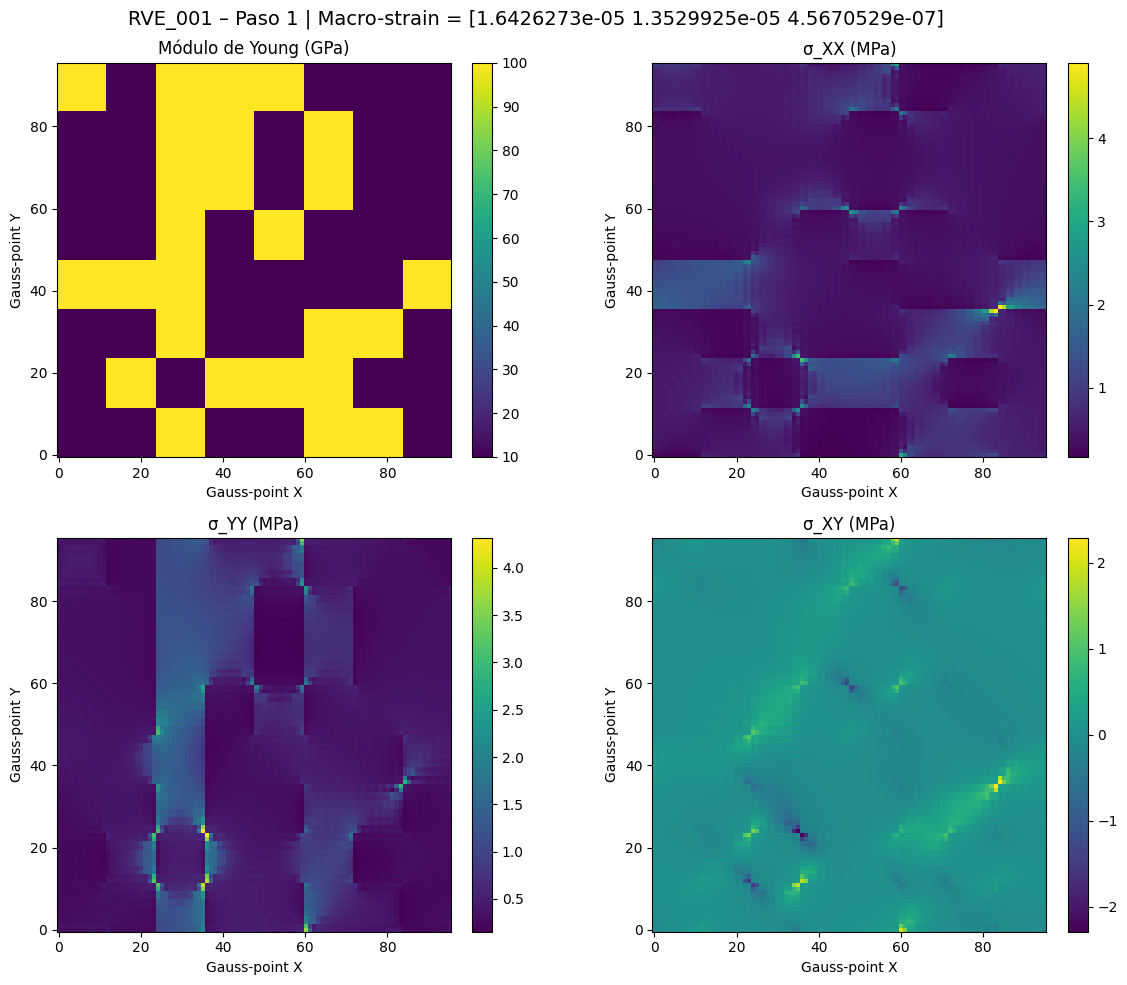

In [ ]:
# ==================== PLOTS DE VERIFICACIÓN ====================
step = -1

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
titles = ['Módulo de Young (GPa)', 'σ_XX (MPa)', 'σ_YY (MPa)', 'σ_XY (MPa)']
data   = [fields[step,:,:,0]/1e3, 
          fields[step,:,:,1],
          fields[step,:,:,2],
          fields[step,:,:,3]]

for i, ax in enumerate(axs.flat):
    im = ax.imshow(data[i], cmap='viridis', origin='lower')
    ax.set_title(titles[i])
    ax.set_xlabel('Gauss-point X')
    ax.set_ylabel('Gauss-point Y')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f'RVE_{1:03d} – Paso {step+1} | Macro-strain = {macro_strain[step]}', fontsize=14)
plt.tight_layout()
plt.show()